# Data Preparation

Shreya D.  
July 10, 2025

We have merged the data from different sources after data extraction, cleaned the typos and made it more usable. We have excluded the articles that did not pass full-text screening and the fitness proxies that we could not find a direction for the effect. These are steps done in the script **05_data_cleaning.Rmd** that generates the file **dataset_after_cleaning.csv**

In this script we will continue to prepare our dataset for use in meta-analysis, calculates variables for effect size estimation (SMDH, lnRR).

#### Input files needed

data/03_data_cleaning/dataset_after_cleaning.csv

#### Output files generated

### Setting up the workspace

In [ ]:
# Setting up workspace
if (!requireNamespace("pacman", quietly = TRUE)) {
  install.packages("pacman")
}
pacman::p_load(here, tidyverse, dplyr, stringr, metafor, orchaRd,ggpubr,ggrepel) #Packages needed

rm(list=ls()) ## cleaning up

set.seed(8341) #set seed for reproducibility (for random number generation)

# Loading cleaned dataset

dataset_after_cleaning <- read_csv(here::here("data/03_data_cleaning/dataset_after_cleaning.csv"))

Rows: 283 Columns: 53
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (30): paper_ID, fulltext_screening, variable_note, authors, population_l...
dbl (22): year_publication, Observation_ID, experiment_ID, group_ID, repeate...
lgl  (1): fulltext_notes

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

#### Loading functions

Some functions we will need in this manuscript.. sourced mainly from Nakagawa 2022 : Online tutorial <https://alistairmcnairsenior.github.io/Miss_SD_Sim/>

In [ ]:
# Function to calculate Geary's "number"
  geary <- function(mean, sd, n){
    (1 / (sd / mean)) * ((4*n^(3/2)) / (1 + 4*n))
  }

  

# Shinichi Nakagawa, Daniel W. A. Noble, Malgorzata Lagisz, Rebecca Spake, Wolfgang Viechtbauer and Alistair M. Senior. 2022. A robust and readily implementable method for the meta-analysis of response ratios with and without missing standard deviations. Ecology Letters, DOI: 10.1111/ele.14144


  # Functions provided in the workalong
cv_avg <- function(x, sd, n, group, data, label = NULL, sub_b = TRUE, cv2=FALSE){

  # Check if the name is specified or not. If not, then assign it the name of the mean, x, variable input in the function. https://stackoverflow.com/questions/60644445/converting-tidyeval-arguments-to-string
  if(is.null(label)){
    label <- purrr::map_chr(enquos(x), rlang::as_label)
  }

  # Calculate between study CV. Take weighted mean CV within study, and then take a weighted mean across studies of the within study CV. Weighted based on sample size and pooled sample size.
  b_grp_cv_data <- data                                             %>%
    dplyr::group_by({{group}})                            %>%
    dplyr::mutate(   w_CV2 = weighted_CV({{sd}}, {{x}}, {{n}}, cv2=cv2),
                     n_mean = mean({{n}}, na.rm = TRUE))   %>%
    dplyr::ungroup(.)                                     %>%
    dplyr::mutate(b_CV2 = weighted.mean(w_CV2, n_mean, na.rm = TRUE), .keep = "used")

  # Make sure that label of the calculated columns is distinct from any other columns
  names(b_grp_cv_data) <- paste0(names(b_grp_cv_data), "_", label)

  # Append these calculated columns back to the original data and return the full dataset.
  if(sub_b){
    b_grp_cv_data <- b_grp_cv_data %>% dplyr::select(grep("b_", names(b_grp_cv_data)))
    dat_new <- cbind(data, b_grp_cv_data)
  } else {
    dat_new <- cbind(data, b_grp_cv_data)
  }

  return(data.frame(dat_new))
}

# You also need the helper function

weighted_CV <- function(sd, x, n, cv2=FALSE){
  if(cv2){
    weighted.mean(na_if((sd / x)^2, Inf), n, na.rm = TRUE)
  }else{
    weighted.mean(na_if((sd / x), Inf), n, na.rm = TRUE)^2
  }
}


#' @title lnrr_laj
#' @description Calculates log response ratio based on Taylor expansion from Jajeunesse 2011
#' @param m1 Mean of treatment group 1
#' @param m2 Mean of treatment group 2
#' @param cv1_2 Coefficient of variation squared (CV^2) for treatment group 1
#' @param cv2_2 Coefficient of variation squared (CV^2) for treatment group 2
#' @param n1 Sample size for treatment group 1
#' @param n2 Sample size for treatment group 2
#' @param taylor A logical indicating whether to calculate point estimate with Taylor expansion.
#'
lnrr_laj <- function(m1, m2, cv1_2, cv2_2, n1, n2, taylor=TRUE){
  if(taylor){
    log(m1 / m2) + 0.5*((cv1_2 / n1) - (cv2_2 / n2))
  } else {
    log(m1 / m2)
  }
}

#' @title v_lnrr_laj
#' @description Calculates the sampling variance for log response ratio based on second order Taylor expansion proposed by Lajeunesse 2011
#' @param cv1_2 Coefficient of variation squared (CV^2) for treatment group 1
#' @param cv2_2 Coefficient of variation squared (CV^2) for treatment group 2
#' @param n1 Sample size for treatment group 1
#' @param n2 Sample size for treatment group 2
#' @param taylor A logical indicating whether to calculate point estimate with Taylor expansion.
v_lnrr_laj <- function(cv1_2, cv2_2, n1, n2,  taylor=TRUE){
  if(taylor){
  ((cv1_2) / n1) + ((cv2_2) / n2) +
    ((cv1_2)^2 / (2*n1^2)) + ((cv2_2)^2 / (2*n2^2))
  } else {
    ((cv1_2) / n1) + ((cv2_2) / n2)
  }
}

# Preparing Random Effects

In our pre-registration, we considered the following levels of non-independence for our analysis:

“(1) paper_ID, which encompasses estimates extracted from the same primary study,

1.  experiment_ID,

2.  group_ID

3.  repeated_traits_ID, and

4.  observation_ID which corresponds to a unit-level observation identity and models within-study variance

As mentioned above, if we obtain additional effect sizes for other bird species after we update our search and/or contact authors, our models may need to account for phylogenetic nonindependence via the inclusion of two additional random effects: “species” and “phylogeny” following Cinar et al. (2022).”

-   We also need to add `observation ID` which is the unit-level identity (unique for each row) for within-study variance.

-   In the way we extracted this information, each paper_ID needs to be added to the random effect level of `experiment_ID`, `group_ID` and `repeated_trait_ID` to make sure they are unique values.

In [ ]:
dataset_analysis<-dataset_analysis%>%
  
  mutate(Observation_ID = as.factor(row_number()))%>%
  
  mutate(experiment_ID_coded = as.factor(paste(paper_ID, experiment_ID, sep="_")),.after=experiment_ID)%>%
  mutate(group_ID_coded = as.factor(paste(paper_ID, group_ID, sep="_")),.after=group_ID)%>%
  mutate(repeated_trait_ID_coded = as.factor(paste(paper_ID,repeated_trait_ID, sep="_")),.after=repeated_trait_ID)

# random_effects_check<-dataset_analysis%>%select(paper_ID,experiment_ID,group_ID,repeated_trait_ID, experiment_ID_coded,group_ID_coded, repeated_trait_ID_coded)

-   We also decided to add `population ID` since we noticed several studies were performed in the same geographical location.

In [ ]:
dataset_analysis<-dataset_analysis%>%
  mutate(population_ID = as.factor(population_location))

# Let's look at the nammes of the locations
# unique(dataset_analysis$population_ID)

# There are clearly many repeated names, let's clean this up a bit

dataset_analysis <- dataset_analysis %>%
  mutate(
    population_ID = str_squish(as.character(population_location)),  # Clean whitespace
    population_ID = case_when(
      # Lodz
      str_detect(population_ID, regex("lodz|łódź|central poland", ignore_case = TRUE)) ~ "Lodz, Poland",
      
      # Montijo / Tagus Estuary
      str_detect(population_ID, regex("montijo|tagus estuary|air force base", ignore_case = TRUE)) ~ "Montijo, Portugal",
      
      # Madrid Region
      str_detect(population_ID, regex("madrid|manzanares|villalba|soto del real|central spain", ignore_case = TRUE)) ~ "Madrid Province, Spain",
      
      # Nova Scotia / New Brunswick
      str_detect(population_ID, regex("nova scotia|new brunswick", ignore_case = TRUE)) ~ "Nova Scotia and New Brunswick, Canada",
      
      # Vosbergen
      str_detect(population_ID, regex("vosbergen|groningen", ignore_case = TRUE)) ~ "Vosbergen, Netherlands",
      
      # Hoya de Guadix
      str_detect(population_ID, regex("hoya de guadix|calahorra|hueneja", ignore_case = TRUE)) ~ "Hoya de Guadix, Spain",
      
      # Valsaín
      str_detect(population_ID, regex("valsain|segovia", ignore_case = TRUE)) ~ "Valsaín, Spain",
      
      # Vanderhoof
      str_detect(population_ID, regex("vanderhoof", ignore_case = TRUE)) ~ "Vanderhoof, Canada",
      
      # Patuxent
      str_detect(population_ID, regex("patuxent|laurel, maryland", ignore_case = TRUE)) ~ "Patuxent Wildlife Research Center, USA",
      
      # Betty Daw’s Wood
      str_detect(population_ID, regex("betty daw", ignore_case = TRUE)) ~ "Betty Daw’s Wood, UK",
      
      # Lake Ammersee
      str_detect(population_ID, regex("ammersee|south germany|andechs", ignore_case = TRUE)) ~ "Lake Ammersee, Germany",
      
      # Corsica
      str_detect(population_ID, regex("corsica|muro valley|quercus", ignore_case = TRUE)) ~ "Corsica, France",
      
      # SWRC Philadelphia
      str_detect(population_ID, regex("swrc|philadelphia", ignore_case = TRUE)) ~ "SWRC, Philadelphia, USA",
      
      # Coimbra
      str_detect(population_ID, regex("coimbra|mata nacional do choupal", ignore_case = TRUE)) ~ "Coimbra, Portugal",
      
      # Kuankuoshui
      str_detect(population_ID, regex("kuankuoshui", ignore_case = TRUE)) ~ "Kuankuoshui Nature Reserve, China",
      
      # Werther
      str_detect(population_ID, regex("werther|52°06′n|52°06’n", ignore_case = TRUE)) ~ "Werther, Germany",
      
      # Bergen
      str_detect(population_ID, regex("bergen", ignore_case = TRUE)) ~ "Bergen, Norway",
      
      # for clean but unmatched names
      TRUE ~ str_to_title(population_ID)
    )
  )

# Effective Sample Size Calculation

For comparisons involving the shared control or treatment groups across multiple studies, we adjust the sample sizes by dividing them by the number of times each group is included in comparisons. This adjustment helps to prevent any inflation of the effect sizes due to repeated use of the same groups and account for the shared-group non-independence.

In [ ]:
dataset_analysis<-dataset_analysis%>%
  mutate(effective_n_experiment=(n_experiment/shared_experiment),.after=n_experiment)%>%
  mutate(effective_n_control=(n_control/shared_control),.after=n_control)

Checking the range of effective sample size in our dataset

In [ ]:
dataset_analysis%>%
  summarise(control_min=min(effective_n_control,na.rm=T),
            control_max=max(effective_n_control,na.rm=T),
            na_control = sum(is.na(effective_n_control)),
            experiment_min=min(effective_n_experiment,na.rm=T),
            experiment_max=max(effective_n_experiment,na.rm=T),
             na_experiment = sum(is.na(effective_n_experiment)))

# A tibble: 1 × 6
  control_min control_max na_control experiment_min experiment_max na_experiment
        <dbl>       <dbl>      <int>          <dbl>          <dbl>         <int>
1           1          99          0              1            111             0

We have some NA and some values of effective sample size 1 and below.. lets see where this is

In [ ]:
low_sample<-dataset_analysis%>%
  filter(effective_n_control<2 | effective_n_experiment<2)

Many of these data points come from GNM_355. There are datapoints with sample size of 1 for some groups. We have extracted data by days and months.. I will combine these for this paper because of such low sample size.

After combining or those I could not combine.. some still have a low sample size..

We can only estimate SMHD with dF (n1+n2-2) greater than 1. lnRR could be calculated regardless. So I will not exclude any rows specifically even though the effective sample size could be lower than 2 in a group.

# Converting variance to SD

There were no other measure of dispersion, only SE and SD, so no need to convert anything more.

In [ ]:
## Calculating sd from difference variance measures (only for se so far)

# For experimental group
dataset_analysis <- dataset_analysis %>%
  mutate(sd_experiment = if_else(type_measure_dispersion_experiment %in% c('se', 'SE'), #condition to check
      measure_dispersion_experiment * sqrt(as.numeric(n_experiment)), # do this if true
      measure_dispersion_experiment), #else do this
      .after=measure_dispersion_experiment)
# For control group
dataset_analysis <- dataset_analysis %>%
  mutate(sd_control = if_else(type_measure_dispersion_control %in% c('se', 'SE'), #condition to check
      measure_dispersion_control* sqrt(as.numeric(n_control)), # do this if true
      measure_dispersion_control), #else do this
      .after=measure_dispersion_control)

Some checks for the value of mean and SD

In [ ]:
# Some rows contain NAs, check why
# contains_NA<-dataset_analysis%>%
# filter(is.na(measure_central_tendency_experiment)|is.na(measure_dispersion_experiment))

# 24 rows contain NA and I checked them manually, everything looks okay. 
# - 4 rows contain only statistical test values and 
# - 4 rows contain values for contingency tables only
# - 16 are missing data that authors did not provide for which we will use 0 as effect size. 

# No effect size provided

Authors did not report the means/effect size for some cases but said they found no difference between the group. For these cases, we will assume the effect size to be exactly zero.

We will calculate the mean trait values by trait type (e.g. physiological, reproductive, etc.) We calculate the mean of both treatment and control group. Then I will assign this mean trait value to all the fitness proxies of that trait type. This way, the difference X1-X2 would be 0 (for SMDH) as well as the log(X1/X2) would also be zero (for log response ratio). Using this, we will then impute the SD for the effect size.

We imputed its sampling variance using the missing-case approach described for lnRR. (see *Nakagawa, S., Noble, D.W.A., Lagisz, M., Spake, R., Viechtbauer, W. & Senior, A.M. (2023) A robust and readily implementable method for the meta-analysis of response ratios with and without missing standard deviations. Ecology Letters, 26, 232–244. Available from: <https://doi.org/10.1111/ele.14144>* for more details)

Using the formula (n1+n2)/(n1×n2)(n_1 + n_2)/(n_1 \times n_2)(n1​+n2​)/(n1​×n2​) for SMDH (see *Lajeunesse, Marc J., ‘Recovering Missing or Partial Data from Studies: A Survey of Conversions and Imputations for Meta-analysis’, in Julia Koricheva, Jessica Gurevitch, and Kerrie Mengersen (eds), Handbook of Meta-analysis in Ecology and Evolution (Princeton, NJ, 2013; online edn, Princeton Scholarship Online, 19 Oct. 2017), <https://doi.org/10.23943/princeton/9780691137285.003.0013>, accessed 5 July 2025* for more details)  
  
We will also run a sensitivity analysis without these proxies to ensure robustness of our results.

In [ ]:
# To calculate means by groups
trait_mean<- dataset_analysis%>%
  group_by(trait_type)%>%
  summarise(
    cumulative_mean = mean (
      c(measure_central_tendency_experiment,measure_central_tendency_control),
      na.rm=T
    ),
    count = n()
  )%>%
  arrange(desc(count))

# Now I need to assign the mean values from this to the missing ES proxies
dataset_analysis<-dataset_analysis%>%
  left_join(trait_mean, by= "trait_type")%>%
  mutate(measure_central_tendency_experiment = if_else((
    proxy_comment == "use 0 as ES" & !is.na(proxy_comment)),
    cumulative_mean,
    measure_central_tendency_experiment),
    measure_central_tendency_control = if_else((
    proxy_comment == "use 0 as ES" & !is.na(proxy_comment)),
    cumulative_mean,
    measure_central_tendency_control),)%>%
  select(-cumulative_mean)

# Effect Size Estimation

## Calculate lnRR

### Geary’s Test

In [ ]:
# Assumption of normality assumed to be approximately correct when values are >= 3.
dataset_analysis<- dataset_analysis %>% 
         mutate(geary_control = geary(measure_central_tendency_control,
                                      sd_control, 
                                      n_control),
                    geary_trt = geary(measure_central_tendency_experiment,
                                      sd_experiment, 
                                      n_experiment),
                   geary_test = ifelse(geary_control >= 3 & geary_trt >= 3, "pass", "fail"))

# How many fail?
    geary_res <-dataset_analysis %>% group_by(geary_test) %>% summarise(n = n()) %>%  data.frame()
    
    geary_res

  geary_test   n
1       fail  48
2       pass 211
3       <NA>  24

**48 observations fail Geary’s test.**

However, we do not exclude anything but as suggested by Lajeunesse (2015), I will do a sensitivity analysis with and without these effect sizes for lnRR.

Since lnRR can only be calculated for ratio scale data (i.e., data with a true zero; among other assumptions), we will exclude effect sizes with a negative value when calculating lnRR.

In [ ]:
## ─────────────────────────────────────────────────────────────
## 1.  Keeping rows where lnRR can be calculated. 
## Inferential stats and contingency table can only be used for SMDH.
##    — store the dropped rows to inspect and join back later
## ─────────────────────────────────────────────────────────────

only_SMDH <-dataset_analysis%>%
  filter(proxy_decision == "contingency table"
         |proxy_decision == "SMDH only")

dataset_analysis <- dataset_analysis %>%
  anti_join(only_SMDH, by = names(dataset_analysis))

## -------------------------------------------------------------------------
## 2. Rows whose means are > 0 (lnRR needs ratio scale data)
##  - store the dropped rows to inspect and join back later to the dataset
## -------------------------------------------------------------------------

neg_means<- dataset_analysis%>%
 filter(measure_central_tendency_experiment <= 0 |
         measure_central_tendency_control <= 0)

dataset_analysis <- dataset_analysis %>%
  anti_join(neg_means, by = names(dataset_analysis))

## -------------------------------------------------------------------------
## 3. Estimating lnRR using metafor::escalc for cases where SD is available
## -------------------------------------------------------------------------

# Using function 'escalc()' (with measure=ROM and 'vtype=LS')

dataset_analysis<- escalc(measure = "ROM", 
              vtype= "LS",
                        n1i = effective_n_experiment, 
                        n2i = effective_n_control,
                        m1i = measure_central_tendency_experiment, 
                        m2i = measure_central_tendency_control,
                        sd1i = sd_experiment, 
                        sd2i = sd_control,
                        data = dataset_analysis, 
                        var.names = c('lnRR',
                                      'lnRR_variance'),
                        add.measure = FALSE,
                        append = TRUE)

## How many lnRR were not calculates?

not_calculated<-dataset_analysis%>%filter(is.na(lnRR)|is.na(lnRR_variance))

## 16 rows have missing values of ES.. we have to impute the values here..

## -------------------------------------------------------------------------
## 4. Estimating lnRR using Missing Case approach from Nakagawa 2022
##    see https://alistairmcnairsenior.github.io/Miss_SD_Sim/
## -------------------------------------------------------------------------

# A: Calculate the average between study CV, which will replace missing values.
   # Study-level pooled CV² (square of weighted-average CV)
   # – one call per group, using your cv_avg() helper

dataset_analysis <- cv_avg(x = measure_central_tendency_experiment, 
                           sd = sd_experiment,
                           n = effective_n_experiment, 
                           group = paper_ID, 
                           label = "exp",
                           data = dataset_analysis)
dataset_analysis <- cv_avg(measure_central_tendency_control, 
                           sd = sd_control,
                           n = effective_n_control, 
                           group = paper_ID, 
                           label = "con",
                           data = dataset_analysis)
# B: Keep study-specific CV² when SD present and pooled CV² when SD is missing


dataset_analysis <- dataset_analysis %>%
  mutate(cv_Control= sd_control/measure_central_tendency_control,
         cv_Experimental= sd_experiment/measure_central_tendency_experiment,
         cv2_con_new = if_else(is.na(sd_control),
                               b_CV2_con,          # pooled CV²
                               cv_Control^2),      # study-specific CV²
         cv2_exp_new = if_else(is.na(sd_experiment),
                               b_CV2_exp,
                               cv_Experimental^2))


# C: Lajeunesse Eqs. 6 & 7 for EVERY row using lnrr_laj and v_lnrr_laj functions
## As would be recommended for ALL CASE method from Nakagawa 2022. 

dataset_analysis <- dataset_analysis %>%
  mutate(lnrr_laj = lnrr_laj(m1 = measure_central_tendency_experiment,
                             m2 = measure_central_tendency_control,
                             cv1_2 = cv2_exp_new,
                             cv2_2 = cv2_con_new,
                             n1 = effective_n_experiment,
                             n2 = effective_n_control),
         v_lnrr_laj = v_lnrr_laj(cv1_2 = cv2_exp_new,
                                 cv2_2 = cv2_con_new,
                                 n1 = effective_n_experiment,
                                 n2 = effective_n_control))


## -------------------------------------------------------------------------
## 4. Replace NA ("use 0 as ES") cases in lnRR/lnRR_variance with imputed values
## -------------------------------------------------------------------------


dataset_analysis<-dataset_analysis%>%
  mutate(lnRR = if_else((
    proxy_comment == "use 0 as ES" & !is.na(proxy_comment)),
    lnrr_laj,
    lnRR),
   lnRR_variance = if_else((
    proxy_comment == "use 0 as ES" & !is.na(proxy_comment)),
    v_lnrr_laj,
    lnRR_variance),)%>%
select(-b_CV2_exp,-b_CV2_con,-cv_Control,-cv_Experimental,-cv2_con_new,-cv2_exp_new,-lnrr_laj,-v_lnrr_laj)


## How many lnRR were not calculated now?

not_calculated<-dataset_analysis%>%filter(is.na(lnRR)|is.na(lnRR_variance))

## All rows have a value, good.. this is what would be expected.


## -------------------------------------------------------------------------
## 5. Adding back the removed rows with NA values for the new columns
## We still have to use these for calculating SMDH values in the dataset
## -------------------------------------------------------------------------

dataset_analysis<-bind_rows(dataset_analysis,only_SMDH,neg_means)

### Sign for Effect Size

We have to ensure throughout the dataset that positive values mean higher estimates of fitness in the experimental group compared to their control counterparts by multiplying all the effect sizes by their corresponding sign **(stored in variable proxies_sign)**, i.e., by -1 or +1.

In [ ]:
dataset_analysis<-dataset_analysis%>%
  mutate(lnRR_sign=lnRR*proxies_sign)

### Outliers Check

We do not plan to exclude any outliers as long as the extracted data is seemingly correct.

Now let’s plot means and SD to see everything looks okay

In [ ]:
# ## We have to exclude the datapoints where we do not have dispersion value. We have added 0 ES in some cases and this is not allowing the lm line to be plotted
# #
# temp_data<-dataset_analysis%>%
#   filter(!is.na(measure_dispersion_experiment) & !is.na(measure_dispersion_control) & !is.na(measure_central_tendency_experiment) & !is.na(measure_central_tendency_control) & !is.na(lnRR))
# dataset_lnRR_plot<-temp_data
# 
# outliers_experiment<- dataset_lnRR %>%
#   filter(measure_dispersion_experiment>100)
# outliers_control<- dataset_lnRR %>%
#   filter(measure_dispersion_control >100)
# 
# 
# # For experimental group
# 
# # Fit a linear model to extract the intercept
# lm_fit_experiment <- lm(log(measure_dispersion_experiment) ~
#                           log(measure_central_tendency_experiment),
#                         data = dataset_lnRR_plot)
# intercept_value_experiment <- coef(lm_fit_experiment)[1] # Extract the intercept
# 
# lm_fit_control <- lm(log(measure_dispersion_control) ~
#                        log(measure_central_tendency_control),
#                      data = dataset_lnRR_plot)
# intercept_value_control <- coef(lm_fit_control)[1]
# 
# # Scatter plot of means vs SDs for experimental group
# dataset_lnRR_plot %>%
#   ggplot(aes(x = log(measure_central_tendency_experiment),
#              y = log(measure_dispersion_experiment),
#              size = effective_n_experiment,
#              colour = trait_type)) +
#   geom_point(alpha = 0.6) +
#   geom_text_repel(
#     data = outliers_experiment,
#     aes(
#       x = log(measure_central_tendency_experiment),
#       y = log(measure_dispersion_experiment),
#       label = fitness_proxy_cleaned
#     ),
#     size = 3, color = "black", max.overlaps = 15
#   ) +
#   geom_smooth(
#     method = "lm",  # Adds a regression line
#     se = TRUE,      # Adds confidence intervals
#     color = "blue", # Color of the line
#     linetype = "solid",# Style of the line
#     size = 0.4
#   ) +
#   # Add a line representing correlation of 1
#   geom_abline(
#     slope = 1,       # Slope of the line
#     intercept = intercept_value_experiment,   # Intercept of the line
#     color = "black", # Color of the line
#     linetype = "dashed", # Style of the line
#     size = 0.4       # Thickness of the line
#   )+
#   labs(
#     x = "Log Mean Value",
#     y = "Log Standard Deviation (SD)",
#     title = "Log-transformed Experimental Groups"
#   ) +
#   theme_minimal() +
#   theme(
#     plot.title = element_text(size = 12, face = "bold"),
#     axis.title = element_text(size = 10),
#     axis.text = element_text(size = 10)
#   )
# 
# # For Control group
# 
# # Scatter plot of means vs SDs for experimental group
# dataset_lnRR_plot %>%
#   ggplot(aes(x = log(measure_central_tendency_control),
#              y = log(measure_dispersion_control),
#              size = effective_n_control)) +
#   geom_point(color = "brown", alpha = 0.6) +
#   geom_text_repel(
#     data = outliers_control,
#     aes(
#       x = log(measure_central_tendency_control),
#       y = log(measure_dispersion_control),
#       label = fitness_proxy_cleaned
#     ),
#     size = 3, color = "black", max.overlaps = 15
#   ) +
#   geom_smooth(
#     method = "lm",  # Adds a regression line
#     se = TRUE,      # Adds confidence intervals
#     color = "blue", # Color of the line
#     linetype = "dashed", # Style of the line
#     size= 0.4
#   ) +
#   # Add a line representing correlation of 1
#   geom_abline(
#     slope = 1,       # Slope of the line
#     intercept = intercept_value_control,   # Intercept of the line
#     color = "black", # Color of the line
#     linetype = "dashed", # Style of the line
#     size = 0.4       # Thickness of the line
#   )+
#   labs(
#     x = "Log Mean Value",
#     y = "Log Standard Deviation (SD)",
#     title = "Log-transformed Control Groups"
#   ) +
#   theme_minimal() +
#   theme(
#     plot.title = element_text(size = 12, face = "bold"),
#     axis.title = element_text(size = 10),
#     axis.text = element_text(size = 10),
#     legend.position = "none"
#   )
# 
# 
# # ggarrange(sd_experiment_plot,sd_control_plot,
#                                      ncol = 2,  nrow = 1,
#                                      labels = c("A.", "B.",
#                                                 common.legend = TRUE))

(`geom_point()`).

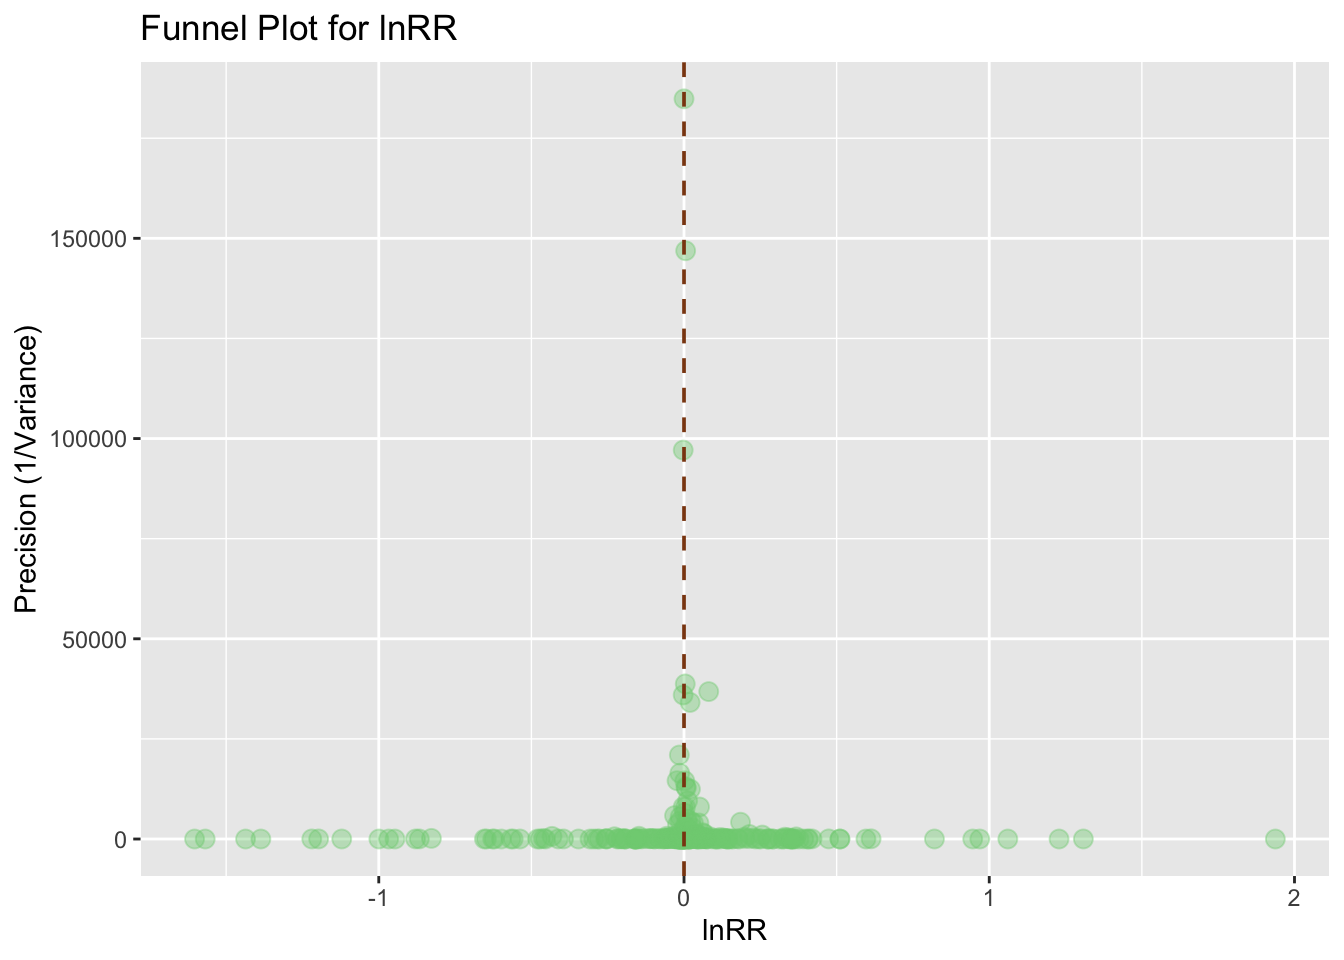

In [ ]:
funnel_lnRR <- dataset_analysis %>%
  ggplot(aes(x = lnRR_sign, y = 1 / lnRR_variance)) +
  geom_point(color= "#7DCE82", alpha = 0.4, size = 3) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "#8B4513", linewidth=0.65) +  # Add vertical dashed line at x = 0
  ggtitle("Funnel Plot for lnRR") +
  xlab("lnRR") +
  ylab("Precision (1/Variance)")

print(funnel_lnRR)

In [ ]:
log_values <- dataset_analysis %>%
  filter(str_detect(variable_note, regex("log", ignore_case = TRUE)))

## Calculate SMDH

-   For results only reported as inferential statistics (e.g., t-test, chi-square), we will use the equations provided by (Lajeunesse 2013; Nakagawa and Cuthill 2007; and other sources if needed) to calculate their corresponding SMD estimates for the analyses.

-   Note that lnRR cannot be calculated from inferential statistics and that only SMD without heteroskedasticity correction can be calculated from inferential statistics.

In [ ]:
#-------------------------------------------------------------------------
# 1. SMDH for most cases where mean, variance and sample size was reported
#-------------------------------------------------------------------------

## using function 'escalc()' with measure=SMDH and 'vtype=LS'

dataset_analysis<- escalc(measure = "SMD", 
              vtype= "LS",
                        n1i = effective_n_experiment, 
                        n2i = effective_n_control,
                        m1i = measure_central_tendency_experiment, 
                        m2i = measure_central_tendency_control,
                        sd1i = sd_experiment, 
                        sd2i = sd_control,
                        data = dataset_analysis, 
                        var.names = c('SMDH',
                                      'SMDH_variance'),
                        add.measure = FALSE,
                        append = TRUE)

# Cases where it was not calculated using mean, variance and sample size
noSMDH<-dataset_analysis%>%filter(is.na(SMDH))

#-------------------------------------------------------------------------
# 2. No effect of the treatment is present but 
# estimates (means, test statistics or effect size) were not reported
#-------------------------------------------------------------------------

# Since authors report no significant effect of the treatment, 
# we assume that the means are not different in the treatment and control group. 
# Under this assumption SMD = M(treatment)-M(control)/SD(pooled) which would be zero
# and the associated variance = n(treatment)+n(control)/n(treatment)+n(control)

dataset_analysis <- dataset_analysis %>%
  mutate(SMDH = if_else(proxy_comment == "use 0 as ES" & !is.na(proxy_comment), (measure_central_tendency_experiment-measure_central_tendency_control), SMDH))%>%
  mutate(SMDH_variance = if_else(proxy_comment == "use 0 as ES" & !is.na(proxy_comment), ((effective_n_experiment+effective_n_control)/(effective_n_experiment*effective_n_control)), SMDH_variance))

# Cases where it was not calculated using mean, variance and sample size
noSMDH<-dataset_analysis%>%filter(is.na(SMDH))

#### Data as contingency table

**IMPORTANT NOTE**: For calculation from contingency tables, the measure of central tendency is used to store value of percentage of success reported. It is not a measure of central tendency.

For cases when the data is reported as a contingency table. In these cases we will calculate the Odds ratio and convert it to SMD.. (and not SMDH)

General Calculation Formulas

1.  **Number of Successes and Failures**

    -   Success in Group A: $S_A = \left(\frac{p_A}{100}\right) \times N_A$

    -   Failure in Group A: $F_A = N_A - S_A$

    -   Success in Group B: $S_B = \left(\frac{p_B}{100}\right) \times N_B$

    -   Failure in Group B: $F_B = N_B - S_B$

        where N is Total Sample Size and P is the number of successful nests

2.  **Odds Ratio (OR)**  
    $$OR = \frac{S_A \times F_B}{S_B \times F_A}$$

3.  **Log Odds Ratio (lnOR)**  
    $$\ln(OR) = \log \left( \frac{S_A \times F_B}{S_B \times F_A} \right)$$

4.  **Variance of Log Odds Ratio (lnOR)**

    $$ V_{\ln OR} = \frac{1}{2} \left( \frac{1}{S_A} + \frac{1}{F_A} + \frac{1}{S_B} + \frac{1}{F_B} \right)$$

5.  **Standardized Mean Difference (SMD)**

    $$SMD = \frac{\ln(OR) \times \sqrt{3}}{\pi}$$

6.  **Variance of Standardized Mean Difference (SMD)**

    $$V_{SMD} = \frac{3 \times V_{\ln OR}}{\pi^2}$$

In [ ]:
contingency_table<-dataset_analysis%>%filter(proxy_decision=="contingency table")

unique(contingency_table$fitness_proxy)

[1] "nests with complete reproductive success (%)"
[2] "Percent Survived"                            

#### For SMDH from ANCOVA and t-test

Note that, since we did not have access to the corresponding $R^2$ values, using Equation 1 for transforming F-values from an ANCOVA into Cohen’s d, we will use Equation 2 instead.

Equation 1: Estimating Cohen’s d from independent groups using ANCOVA

<figure>
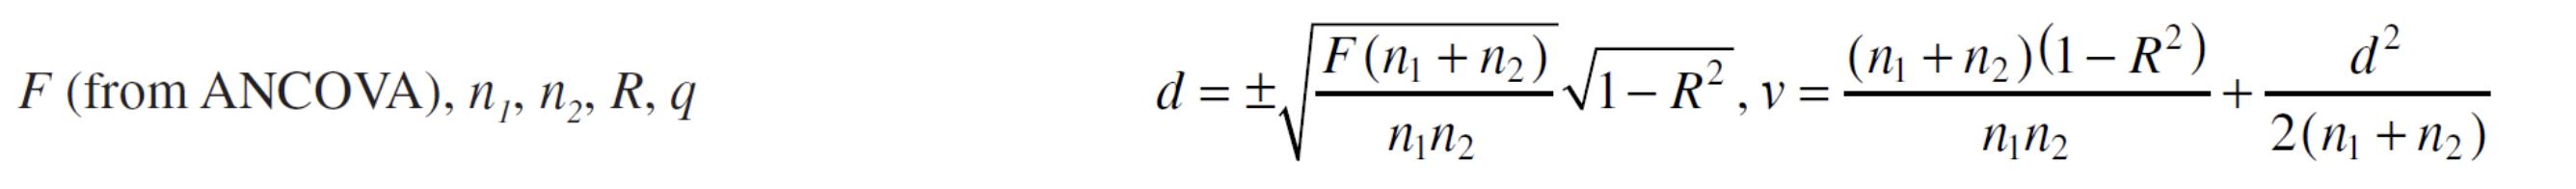
<figcaption aria-hidden="true">From Cooper2019 Table 11.3</figcaption>
</figure>

Equation 2: Estimating Cohen’s d from independent groups using ANOVA

<figure>
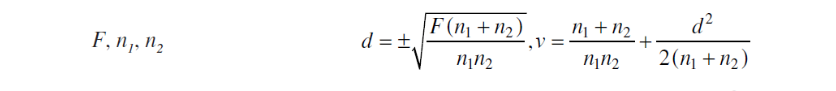
<figcaption aria-hidden="true">From Cooper2019 Table 11.3</figcaption>
</figure>

We will slightly overestimate $d$ and underestimate $V_d$ the larger that unknown $R^2$ value is (see simulation on sensitivity analysis tab); however, we decided to use it to avoid excluding those three effect sizes.

In [ ]:
ancova_SMDH<-dataset_analysis%>%filter(statistics_type=="ANCOVA")
# 3 effect size where SMDH needs to be estimated from ANCOVA 

# Function to compute Cohen's d (from ANOVA)
d_anova <- function(F, n1, n2) {
  sqrt((F * (n1 + n2)) / (n1 * n2))
}

# Function to compute variance (from ANOVA)
var_d_anova <- function(d_anova, n1, n2) {
  ((n1 + n2) / (n1 * n2)) + (d_anova^2 / (2 * (n1 + n2)))
}

ancova_SMDH<-ancova_SMDH%>%
  mutate(SMDH = sign_relationship*(d_anova(statistics_value,n_experiment,n_control)))%>%
    mutate(SMDH_variance = var_d_anova(SMDH, n_experiment,n_control))

# Update SMDH and SMDH_variance based on Observation_ID
dataset_analysis <- rows_update(
  x = dataset_analysis,           # Target dataset to update
  y = ancova_SMDH %>% 
        select(Observation_ID, SMDH, SMDH_variance), # Updates from ancova_SMDH
  by = "Observation_ID"       # Match on Observation_ID
)

<figure>
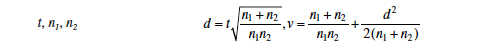
<figcaption aria-hidden="true">from Table 11.1 Cooper2019</figcaption>
</figure>

In [ ]:
# 1 effect size where SMDH needs to be estimated from t-test statistics
t_test_SMDH<-dataset_analysis%>%filter(statistics_type=="t-test")

# Function to compute Cohen's d (from t)
d_t_test <- function(t, n1, n2) {
  t * sqrt((n1 + n2) / (n1 * n2))
}

# Function to compute variance (from t)
var_d_t_test <- function(d_t_test, n1, n2) {
  ((n1 + n2) / (n1 * n2)) + (d_t_test^2 / (2 * (n1 + n2)))
}

t_test_SMDH<-t_test_SMDH%>%
  mutate(SMDH = sign_relationship*(d_t_test(statistics_value,n_experiment,n_control)))%>%
    mutate(SMDH_variance = var_d_t_test(SMDH, n_experiment,n_control))

# Update SMDH and SMDH_variance based on Observation_ID
dataset_analysis <- rows_update(
  x = dataset_analysis,           # Target dataset to update
  y = t_test_SMDH %>% 
        select(Observation_ID, SMDH, SMDH_variance), # Updates from t_test_SMDH
  by = "Observation_ID"       # Match on Observation_ID
)

### Sign for Effect Size

In [ ]:
dataset_analysis<-dataset_analysis%>%
  mutate(SMDH_sign=SMDH*proxies_sign)

### Low sample size

In [ ]:
# 9 from GNM_355 where repeated estimates over days for haemoglobin are present and I cannot combine them as I did for chick mass over months.. since the sample is the same and these are the repeated measures of the same sample.
low_sample=dataset_analysis%>%filter(is.na(SMDH))
write.csv(low_sample,file=here::here("data/03_data_cleaning/low_sample.csv"),row.names = FALSE)

This is very very low sample size, it makes no sense to keep them. I will exclude them from all the further analysis.

In [ ]:
dataset_analysis<-dataset_analysis%>%anti_join(low_sample,by="Observation_ID")

## Saving all output files

In [ ]:
# # Complete dataset that can be used for analysis
# write.csv(dataset_analysis,file=here::here("data/04_data_analysis/dataset_analysis.csv"),row.names = FALSE)
# 
# 
# # Dataset that can be used to estimate lnRR
# 
# dataset_lnRR<-dataset_analysis%>%
#   filter(!is.na(lnRR_sign) & !is.na(lnRR_variance))
# 
# write.csv(dataset_lnRR,file=here::here("data/04_data_analysis/dataset_lnRR.csv"),row.names = FALSE)
# 
# # Dataset that can be used to estimate SMD(H)
# 
# dataset_SMDH<-dataset_analysis%>%
#   filter(!is.na(SMDH_sign) & !is.na(SMDH_variance))
# 
# write.csv(dataset_SMDH,file=here::here("data/04_data_analysis/dataset_SMDH.csv"),row.names = FALSE)